#### Metropolis Algorithm:
#### Trial Phase: $tan^{-1}\bigg[\frac{sin(u)}{cos(u) - 1}\bigg]$
#### u is amplitude part of hologram. $\frac{1}{\alpha}e^{-\frac{\kappa^2\rho^2}{\alpha}} - \frac{1}{\beta}e^{-\frac{\kappa^2\rho^2}{\beta}}$
#### u_des is field at focus. $e^{-\frac{r^2}{\sigma^2}} - e^{-\frac{r^2}{\tau^2}}$. Generate I_d from this. 
#### Initial amplitude is 1 inside aperture, 0 outside.

In [99]:
import numpy as np
from matplotlib import pyplot as plt
import random
import time
#import sys
#np.set_printoptions(threshold=sys.maxsize)

def generate_func(px, py):
#general parameters
    wavelength = 1064e-9/48e-9
    z = 1e-6/48e-9 #f, after thin lens approx.
#work in pixels
    kappa = 1j*np.pi/(wavelength*z)
    tau = 2e-6/48e-9
    sigma = 4e-6/48e-9
    a = (1/(sigma)**2 - kappa)
    b = (1/(tau)**2 - kappa)
#Our field of view is 1280x1024 
    ylist = np.arange(-py/2, px/2+1, 1)
    xlist = np.arange(-py/2, px/2+1, 1)
    my_u_f = np.zeros([len(ylist), len(xlist)]) #a real valued array of focal pt values in px
    my_phase = np.zeros([len(ylist), len(xlist)],dtype="complex") #a complex valued array of hologram values in px
    for yi in range(len(ylist)):
        for xi in range(len(xlist)):
            r = np.sqrt(xlist[xi]**2 + ylist[yi]**2) #r is in px. Remember in SLM plane, it is scaled by wavevector
            #u_holo = (1/a)*np.exp(-kappa**2 * (r/10)**2 / a) - (1/b)*np.exp(-kappa**2 * (r/10)**2 / b)
            u_f = np.exp(-r**2/sigma**2)-np.exp(-r**2/tau**2)
            my_u_f[yi][xi] = u_f
    my_u_f /= np.max(my_u_f)
    my_phase = np.angle(np.sin(my_u_f)/(np.cos(my_u_f)-1))
    #there is a singularity point in my_phase, characterized by u_f=1
    my_phase[np.argwhere(np.isnan(my_phase))[0][0]][np.argwhere(np.isnan(my_phase))[0][1]] = np.pi/2
    plt.figure(0)
    plt.title('Trial Phase')
    plt.imshow(my_phase, cmap = 'gray', interpolation = 'nearest')
    plt.colorbar()
    plt.figure(1)
    plt.title('I_d (at focus)')
    plt.imshow(my_u_f**2, cmap = 'gray', interpolation = 'nearest')
    plt.colorbar()
    return [my_phase, my_u_f]

def transf_function(px, py, xi, eta): #rho_j and phi_j
    #for every pixel in the DOE, there exists a transfer function
    k = 2*np.pi/(1064e-9/48e-9)
    z = 1e-6/48e-9 #f, after thin lens approx.
    ylist = np.arange(-py/2, py/2+1, 1) #assumes px = xmax = 768 = py = ymax. Change accordingly
    xlist = np.arange(-px/2, px/2+1, 1)
    T = np.zeros([len(ylist), len(xlist)],dtype="complex") #a complex valued array of hologram values in px
    for y_i in range(len(ylist)):
        for x_i in range(len(xlist)):
            x = xlist[x_i]
            y = ylist[y_i]
            arg = -1j*k/z * (x*xi + y*eta)
            T[y_i][x_i] = np.exp(arg)
    return T

def metropolis(nruns, px, py): #px and py are size of DOE in pixels. nruns is number of runs
#Step 0: Define phase/amplitudes and get first value for metric.
    arr = generate_func(px, py) #generate_func gives [trial phase array, desired field array]
    phase = arr[0] #trial phase
    I_d = arr[1]**2 #desired intensity
    u = phase/np.max(phase) #array based on aperture size?? Need to set aperture size. 
    runnum = 0
    #calculate metric right away to get a first value:
    gamma = np.sum(I_d*u)/np.sum(u**2)
    sigma = np.sqrt((1/417124) * np.sum((u - gamma*I_d)**2)) #number of pixels within aperture radius = 417124
    C_best_so_far = -np.average(u) + (0.5*sigma)
    print(C_best_so_far)
#start loop:
    while runnum < nruns:
#Step 1: Pick random phase value in phase array, change, get new phase
        runnum += 1
        random_loc = [random.randrange(0,np.size(phase,0)), random.randrange(0,np.size(phase,1))] #random location on the array
        current_angle = phase[random_loc[0]][random_loc[1]] #current value in radians
        updated_phase = phase.copy()
        random_angle = random.choice(np.linspace(0,np.pi, 256)) #should it be [0,2*pi]
        updated_phase[random_loc[0]][random_loc[1]] = random_angle
#Step 2: Propagate change in SLM to focus
        K = np.exp(1j*updated_phase)
        K_inv = np.conj(K)
        eta, xi = random_loc[0]-py/2, random_loc[1]-px/2
        T = transf_function(px, py, xi, eta)
        delta_E = K_inv * T * np.exp(1j*random_angle) * (np.exp(1j*(random_angle-current_angle))-1) * u
#Step 3: Get new field, new intensity
        E = np.exp(1j*phase) * T * np.exp(1j*(current_angle)) * u #existing field
        updated_E = E + delta_E
        I = np.real(updated_E)**2 + np.imag(updated_E)**2
#Step 4: Calculate metric, and compare
        I /= np.max(I.flatten())
        gamma = np.sum(I_d*I)/np.sum(I**2)
        sigma = np.sqrt((1/417124) * np.sum((I - gamma*I_d)**2)) #number of pixels within aperture radius
        C = -np.average(I) + (0.5 * sigma)
        print([gamma,sigma,C])
#Step 5: Accept or reject change
        if abs(C) < abs(C_best_so_far):
            C_best_so_far = C
            E = updated_E
            phase = updated_phase
            print("Accepted ->", C)
#Step 6: Plot results
    plt.figure(2)
    plt.title('New Phase')
    plt.imshow(phase, cmap = 'gray', interpolation = 'nearest')
    plt.colorbar()
    plt.figure(3)
    plt.title('I')
    plt.imshow(I, cmap = 'gray', interpolation = 'nearest')
    plt.colorbar()
    return


<ipython-input-97-dcda2ce9fd83>:30: RuntimeWarning: divide by zero encountered in true_divide
  my_phase = np.angle(np.sin(my_u_f)/(np.cos(my_u_f)-1))
<ipython-input-97-dcda2ce9fd83>:30: RuntimeWarning: invalid value encountered in true_divide
  my_phase = np.angle(np.sin(my_u_f)/(np.cos(my_u_f)-1))


-0.20673050790018005
[0.11094926816535614, 0.46972175142158806, -0.10029061659166097]
Accepted -> -0.10029061659166097
[0.052717571509340366, 0.9972659466837149, -0.2067303271380761]
[0.05271770955702984, 0.9972646267270439, -0.20672909627020647]
[0.052717468753820475, 0.9972669291839646, -0.20673088317599475]
[0.05271771107809749, 0.9972646121970502, -0.2067289886315133]
[0.21038401345991026, 0.24244209821414775, -0.0555190020443487]
Accepted -> -0.0555190020443487
[0.05271570315995105, 0.9972636400653274, -0.20672796000985327]
[0.05271782686761124, 0.9972634209678463, -0.20672807541384702]
[0.052717656544338305, 0.9972650996735266, -0.20672972135551126]
[0.07029380854340879, 0.7463608163439724, -0.15581348544989032]


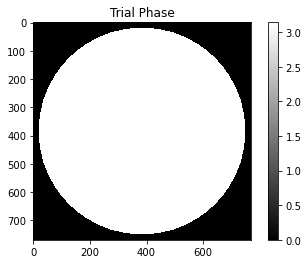

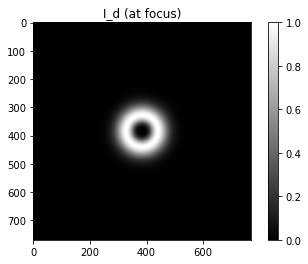

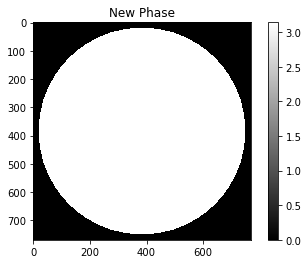

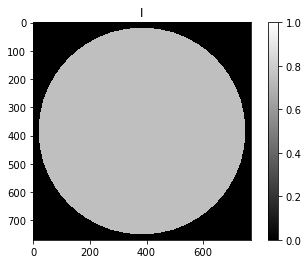

In [98]:
metropolis(10, 768, 768)